In [1]:
import torch
from torch import optim
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingLR
import torch.nn.functional as F
import torch.autograd as autograd
from torch.autograd import Variable
from torch.utils import *
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import gumbel_softmax
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy import linalg

In [3]:
# Or Option 2: Use absolute path
file_path = r"C:\Users\kotsgeo\Documents\GANs\AMPdata.txt"

In [4]:
class SequenceDataset(Dataset):
    def __init__(self, file_path, seq_length=156):
        self.seq_length = seq_length
        self.sequences = []
        self.char_to_idx = {'P': 0, 'A': 1, 'T': 2, 'G': 3, 'C': 4}
        
        # Handle both absolute and relative paths
        if not os.path.isabs(file_path):
            file_path = os.path.join(os.getcwd(), file_path)
            
        try:
            with open(file_path, 'r') as f:
                for line in f:
                    seq = line.strip().split('\t')[0]
                    if len(seq) < seq_length:
                        seq = seq + 'P' * (seq_length - len(seq))
                    seq = seq[:seq_length]
                    self.sequences.append(seq)
            print(f"Successfully loaded {len(self.sequences)} sequences")
            
        except FileNotFoundError:
            raise FileNotFoundError(f"Data file not found at: {file_path}")

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        one_hot = torch.zeros(self.seq_length, len(self.char_to_idx))
        for i, char in enumerate(seq[:self.seq_length]):
            if char in self.char_to_idx:
                one_hot[i][self.char_to_idx[char]] = 1
            else:
                one_hot[i][self.char_to_idx['P']] = 1
        return one_hot

# Test the dataset
if __name__ == "__main__":
    # You can use either relative or absolute path
    # Option 1: Relative path
    dataset = SequenceDataset("AMPdata.txt")
    
    # Option 2: Absolute path
    # dataset = SequenceDataset("/path/to/your/AMPdata.txt")

    # Print first sequence
    first_seq = dataset[0]
    print("First sequence shape:", first_seq.shape)
    print("\nMapping:", dataset.char_to_idx)

    # Create dataloader
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)

    print('\nNumber of sequences:', len(dataloader.dataset))
    
    # Check a batch
    for batch in dataloader:
        print("Batch shape:", batch.shape)
        print("\nSample from batch (showing where P padding is):")
        print(torch.argmax(batch[0], dim=1)[:10])  
        break
dataset = SequenceDataset(file_path)

Successfully loaded 2600 sequences
First sequence shape: torch.Size([156, 5])

Mapping: {'P': 0, 'A': 1, 'T': 2, 'G': 3, 'C': 4}

Number of sequences: 2600
Batch shape: torch.Size([64, 156, 5])

Sample from batch (showing where P padding is):
tensor([1, 2, 3, 3, 3, 4, 1, 2, 2, 2])
Successfully loaded 2600 sequences


In [5]:
class ResBlock(nn.Module):
    def __init__(self, hidden):
        super(ResBlock, self).__init__()
        
        self.hidden_channels = hidden // 4
        
        # Down projection
        self.down_proj = nn.Sequential(
            nn.BatchNorm1d(hidden),
            nn.ReLU(True),
            nn.Conv1d(hidden, self.hidden_channels, 1, padding=0)
        )
        
        # Main processing
        self.main_proc = nn.Sequential(
            nn.BatchNorm1d(self.hidden_channels),
            nn.ReLU(True),
            nn.Conv1d(self.hidden_channels, self.hidden_channels, 5, padding=2),
            
            nn.BatchNorm1d(self.hidden_channels),
            nn.ReLU(True),
            nn.Conv1d(self.hidden_channels, self.hidden_channels, 5, padding=2)
        )
        
        # Up projection
        self.up_proj = nn.Sequential(
            nn.BatchNorm1d(self.hidden_channels),
            nn.ReLU(True),
            nn.Conv1d(self.hidden_channels, hidden, 1, padding=0),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        h = self.down_proj(x)
        h = self.main_proc(h)
        h = self.up_proj(h)
        return x + h
    
class ImprovedGenerator(nn.Module):
    def __init__(self, n_chars, seq_len, batch_size, hidden):
        super(ImprovedGenerator, self).__init__()

        def init_weights(m):
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        self.n_chars = n_chars
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.hidden = hidden
        
        # Start from length 5
        self.bottom_length = 5
        
        # Initial projection
        self.linear = nn.Linear(128, hidden*16*self.bottom_length)
        
        # Progressive upsampling blocks
        # 5 -> 10 -> 20 -> 40 -> 80 -> 156
        self.upscale_factors = [2, 2, 2, 2, 1.95]  # Last step adjusts to reach exactly 156
        
        self.blocks = nn.ModuleList([
            # First block: maintain channels
            nn.Sequential(
                ResBlock(hidden*16),              
                nn.Upsample(scale_factor=self.upscale_factors[0], mode='nearest')  # 5 -> 10
            ),
            
            # Second block: 16ch → 8ch
            nn.Sequential(
                ResBlock(hidden*16),          
                nn.Conv1d(hidden*16, hidden*8, 1),
                nn.Upsample(scale_factor=self.upscale_factors[1])  # 10 -> 20
            ),
            
            # Third block: 8ch → 4ch
            nn.Sequential(
                ResBlock(hidden*8),           
                nn.Conv1d(hidden*8, hidden*4, 1),
                nn.Upsample(scale_factor=self.upscale_factors[2])  # 20 -> 40
            ),
            
            # Fourth block: 4ch → 2ch
            nn.Sequential(
                ResBlock(hidden*4),           
                nn.Conv1d(hidden*4, hidden*2, 1),
                nn.Upsample(scale_factor=self.upscale_factors[3])  # 40 -> 80
            ),
            
            # Fifth block: 2ch → ch
            nn.Sequential(
                ResBlock(hidden*2),           
                nn.Conv1d(hidden*2, hidden, 1),
                nn.Upsample(scale_factor=self.upscale_factors[4])  # 80 -> 156
            )
        ])
        
        # Final layers
        self.final = nn.Sequential(
            nn.BatchNorm1d(hidden),
            nn.ReLU(),
            nn.Conv1d(hidden, n_chars, 3, padding=1)
        )

        self.apply(init_weights)

    def forward(self, noise):
        # Initial projection and reshape
        output = self.linear(noise)  # [64, 5120]
        output = output.view(-1, self.hidden*16, self.bottom_length)  # [64, 1024, 5]
        
        # Through progressive blocks
        for block in self.blocks:
            output = block(output)
            
        # Final processing
        output = self.final(output)  # [64, 5, 156]
        
        # Prepare for Gumbel
        output = output.transpose(1, 2)  # [64, 156, 5]
        shape = output.size()
        output = output.contiguous()
        output = output.view(-1, self.n_chars)  # [9984, 5]
        output = gumbel_softmax(output, 0.5)
        
        return output.view(shape)  # Back to [64, 156, 5]

class UNetDiscriminator(nn.Module):
    def __init__(self, n_chars, seq_len, batch_size, hidden):
        super(UNetDiscriminator, self).__init__()

        def init_weights(m):
            if isinstance(m, (nn.Conv1d, nn.Linear)):
                nn.init.orthogonal_(m.weight, gain=np.sqrt(2))
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

        self.n_chars = n_chars
        self.seq_len = seq_len
        self.batch_size = batch_size
        self.hidden = hidden

        # Initial projection
        self.initial_conv = nn.Conv1d(n_chars, hidden, 1)  # ch

        # Encoder
        self.enc1 = nn.Sequential(
            ResBlock(hidden),              # 64
            nn.Conv1d(hidden, hidden*2, 1),# -> 128
            nn.AvgPool1d(2)               # 156 -> 78
        )

        self.enc2 = nn.Sequential(
            ResBlock(hidden*2),           # 128
            nn.Conv1d(hidden*2, hidden*4, 1),# -> 256
            nn.AvgPool1d(2)               # 78 -> 39
        )

        self.enc3 = nn.Sequential(
            ResBlock(hidden*4),           # 256
            nn.Conv1d(hidden*4, hidden*8, 1),# -> 512
            nn.AvgPool1d(2)               # 39 -> 19
        )

        self.enc4 = nn.Sequential(
            ResBlock(hidden*8),           # 512
            nn.Conv1d(hidden*8, hidden*16, 1),# -> 1024
            nn.AvgPool1d(2)               # 19 -> 9
        )

        # Bottleneck
        self.bottleneck = ResBlock(hidden*16)  # 1024

        # Decoder
        self.dec1 = nn.Sequential(
            ResBlock(hidden*16),          # 1024
            nn.Conv1d(hidden*16, hidden*8, 1),# -> 512
            nn.Upsample(scale_factor=2)    # 9 -> 18
        )
        self.dec1_res = ResBlock(hidden*16)  # After concat (512+512=1024)

        self.dec2 = nn.Sequential(
            ResBlock(hidden*16),          # 1024
            nn.Conv1d(hidden*16, hidden*8, 1),# -> 512
            nn.Upsample(scale_factor=2)    # 19 -> 38
        )
        self.dec2_conv = nn.Conv1d(hidden*12, hidden*16, 1)  # 768->1024
        self.dec2_res = ResBlock(hidden*16)  # After concat adjust

        self.dec3 = nn.Sequential(
            ResBlock(hidden*16),          # 1024
            nn.Conv1d(hidden*16, hidden*4, 1),# -> 256
            nn.Upsample(scale_factor=2)    # 39 -> 78
        )
        self.dec3_conv = nn.Conv1d(hidden*6, hidden*8, 1)  # 384->512
        self.dec3_res = ResBlock(hidden*8)  # After concat adjust

        self.dec4 = nn.Sequential(
            ResBlock(hidden*8),           # 512
            nn.Conv1d(hidden*8, hidden*2, 1),# -> 128
            nn.Upsample(scale_factor=2)    # 78 -> 156
        )
        self.dec4_conv = nn.Conv1d(hidden*3, hidden*4, 1)  # 192->256
        self.dec4_res = ResBlock(hidden*4)  # After concat adjust

        # Global output (from bottleneck)
        self.global_output = nn.Sequential(
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),    
            nn.Flatten(),
            nn.Linear(hidden*16, 1)      
        )

        # Pixel-wise output
        self.pixel_output = nn.Conv1d(hidden*4, 1, 1)

        self.apply(init_weights)

    def pad_end(self, x, target_size):
        """Add padding at the end to reach target_size"""
        diff = target_size - x.size(2)
        if diff > 0:
            return F.pad(x, (0, diff), mode='constant', value=0)
        return x
    
    def forward(self, input):
        # Input shape: (batch_size, seq_len, n_chars)
        x = input.transpose(1, 2)  # (batch_size, n_chars, seq_len)

        # Initial projection
        x = self.initial_conv(x)  # [batch, hidden, 156]
        residuals = [x]

        # Encoder path
        x = self.enc1(x)        # -> 78
        residuals.append(x)
        x = self.enc2(x)        # -> 39
        residuals.append(x)
        x = self.enc3(x)        # -> 19
        residuals.append(x)
        x = self.enc4(x)        # -> 9

        # Bottleneck
        bottleneck = self.bottleneck(x)  # Store bottleneck output

        # Global output
        global_output = self.global_output(bottleneck)
        global_output = torch.sigmoid(global_output)

        # Decoder path with padding and skip connections
        x = self.dec1(bottleneck)  # 9 -> 18
        x = self.pad_end(x, 19)    # pad to 19
        x = torch.cat([x, residuals.pop()], dim=1)
        x = self.dec1_res(x)

        x = self.dec2(x)           # 19 -> 38
        x = self.pad_end(x, 39)    # pad to 39
        x = torch.cat([x, residuals.pop()], dim=1)
        x = self.dec2_conv(x)      # Adjust channels
        x = self.dec2_res(x)

        x = self.dec3(x)           # 39 -> 78
        x = torch.cat([x, residuals.pop()], dim=1)
        x = self.dec3_conv(x)      # Adjust channels
        x = self.dec3_res(x)

        x = self.dec4(x)           # 78 -> 156
        x = torch.cat([x, residuals.pop()], dim=1)
        x = self.dec4_conv(x)      # Adjust channels
        x = self.dec4_res(x)

        # Pixel-wise output
        pixel_output = self.pixel_output(x)
        pixel_output = torch.sigmoid(pixel_output)
        pixel_output = pixel_output.transpose(1, 2)

        return global_output, pixel_output

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [7]:
batch_size = 64

def sample_and_analyze(generator, num_samples=batch_size, epoch=0):
    # Decode function
    inv_charmap = {0:'P', 1:'A', 2:'T', 3:'G', 4:'C'}

    def decode_sequence(seq):
        indices = np.argmax(seq, axis=1)
        return ''.join([inv_charmap[idx] for idx in indices])

    # Generate sequences
    generator.eval()
    with torch.no_grad():
        noise = torch.randn(num_samples, 128).to(device)
        generated_sequences = generator(noise)

        # Convert to list of strings
        decoded_seqs = [decode_sequence(seq.cpu().numpy()) for seq in generated_sequences]

    generator.train()

    return decoded_seqs

def analyze_sequences(seqs):
    # Remove padding sequences
    clean_seqs = [seq.replace('P', '') for seq in seqs]

    # Analysis metrics
    analysis = {
        'total_sequences': len(seqs),
        'sequences_without_padding': len(clean_seqs),

        # Start codon analysis
        'starts_with_atg': sum(1 for seq in clean_seqs if seq.startswith('ATG')),

        # Stop codon analysis
        'ends_with_stop_codon': sum(1 for seq in clean_seqs
                                    if seq.endswith('TAA') or
                                       seq.endswith('TAG') or
                                       seq.endswith('TGA')),

        # Multiple of 3 analysis
        'multiple_of_3': sum(1 for seq in clean_seqs if len(seq) % 3 == 0),

        # All three conditions
        'valid_orfs': sum(1 for seq in clean_seqs 
                         if seq.startswith('ATG') and
                            (seq.endswith('TAA') or seq.endswith('TAG') or seq.endswith('TGA')) and
                            len(seq) % 3 == 0),

        # GC Content analysis
        'gc_content': [],
        'avg_gc_content': 0,
        'min_gc_content': 0,
        'max_gc_content': 0
    }

    # Calculate GC content for each sequence
    for seq in clean_seqs:
        # Count G and C
        gc_count = seq.count('G') + seq.count('C')
        # Calculate GC content percentage
        gc_content = (gc_count / len(seq)) * 100 if len(seq) > 0 else 0
        analysis['gc_content'].append(gc_content)

    # Calculate GC content statistics
    if analysis['gc_content']:
        analysis['avg_gc_content'] = np.mean(analysis['gc_content'])
        analysis['min_gc_content'] = np.min(analysis['gc_content'])
        analysis['max_gc_content'] = np.max(analysis['gc_content'])

    # Calculate percentages
    analysis['start_codon_percentage'] = (analysis['starts_with_atg'] / len(clean_seqs)) * 100 if clean_seqs else 0
    analysis['stop_codon_percentage'] = (analysis['ends_with_stop_codon'] / len(clean_seqs)) * 100 if clean_seqs else 0
    analysis['multiple_of_3_percentage'] = (analysis['multiple_of_3'] / len(clean_seqs)) * 100 if clean_seqs else 0
    analysis['valid_orfs_percentage'] = (analysis['valid_orfs'] / len(clean_seqs)) * 100 if clean_seqs else 0

    return analysis

def save_analysis(generated_seqs, epoch):
    # Perform analysis
    seq_properties = analyze_sequences(generated_seqs)

    # Create filename
    filename = os.path.join(results_dir, f'analysis_epoch_{epoch}.txt')

    # Write to file
    with open(filename, 'w') as f:
        # First, write all generated sequences
        f.write("Generated Sequences:\n")
        f.write("-" * 20 + "\n")
        for i, seq in enumerate(generated_seqs, 1):
            f.write(f"Sequence {i}: {seq}\n")

        # Then write analysis results
        f.write("\n\nSequence Analysis:\n")
        f.write("-" * 20 + "\n")
        f.write(f"Total Sequences: {seq_properties['total_sequences']}\n")
        f.write(f"Sequences without padding: {seq_properties['sequences_without_padding']}\n")

        f.write("\nStart Codon Analysis:\n")
        f.write(f"Starts with ATG: {seq_properties['starts_with_atg']} "
                f"({seq_properties['start_codon_percentage']:.2f}%)\n")

        f.write("\nStop Codon Analysis:\n")
        f.write(f"Ends with stop codon: {seq_properties['ends_with_stop_codon']} "
                f"({seq_properties['stop_codon_percentage']:.2f}%)\n")

        f.write("\nSequence Length Analysis:\n")
        f.write(f"Sequences multiple of 3: {seq_properties['multiple_of_3']} "
                f"({seq_properties['multiple_of_3_percentage']:.2f}%)\n")

        f.write("\nValid ORFs Analysis:\n")
        f.write(f"Sequences with all conditions (start, stop, multiple of 3): {seq_properties['valid_orfs']} "
                f"({seq_properties['valid_orfs_percentage']:.2f}%)\n")

        f.write("\nGC Content Analysis:\n")
        f.write(f"Average GC Content: {seq_properties['avg_gc_content']:.2f}%\n")
        f.write(f"Minimum GC Content: {seq_properties['min_gc_content']:.2f}%\n")
        f.write(f"Maximum GC Content: {seq_properties['max_gc_content']:.2f}%\n")

In [8]:
# Define results directory with absolute path
results_dir = r"C:\Users\kotsgeo\Documents\GANs\GANs\ResultsNoMix"

In [9]:
from itertools import product
from collections import Counter
from scipy.spatial.distance import jensenshannon

# 1. Convert one-hot or Gumbel-softmax output to DNA string
def tensor_to_dna(seq_tensor):
    idx_to_base = ['P', 'A', 'T', 'G', 'C']
    indices = torch.argmax(seq_tensor, dim=-1)
    return ''.join([idx_to_base[i] for i in indices.tolist() if idx_to_base[i] != 'P'])

# 2. Get k-mer distribution
def get_kmer_distribution(seqs, k=6):
    all_kmers = [''.join(p) for p in product('ACGT', repeat=k)]
    kmer_counts = Counter()
    for seq in seqs:
        for i in range(len(seq) - k + 1):
            kmer = seq[i:i+k]
            kmer_counts[kmer] += 1
    total = sum(kmer_counts.values())
    freq = np.array([kmer_counts[kmer] for kmer in all_kmers], dtype=np.float32)
    return freq / (total + 1e-8)

# 3. Evaluate per epoch
def evaluate_kmer_jsd(real_batch, gen_batch, k=6):
    real_seqs = [tensor_to_dna(seq) for seq in real_batch]  # shape: (batch_size, seq_len, 4)
    gen_seqs  = [tensor_to_dna(seq) for seq in gen_batch]

    real_dist = get_kmer_distribution(real_seqs, k=k)
    gen_dist  = get_kmer_distribution(gen_seqs, k=k)

    jsd = jensenshannon(real_dist, gen_dist)
    return jsd

def evaluate_multiple_batches(generator, dataloader, num_batches=5, k=6):
    generator.eval()  # Set to evaluation mode
    total_jsd = 0.0
    
    with torch.no_grad():
        for i in range(num_batches):
            # Get real batch
            try:
                real_batch = next(iter(dataloader)).to(device)
            except StopIteration:
                dataloader_iter = iter(dataloader)
                real_batch = next(dataloader_iter).to(device)
            
            # Generate fake batch
            noise = torch.randn(real_batch.size(0), 128).to(device)
            fake_batch = generator(noise)
            
            # Calculate JSD for this batch
            batch_jsd = evaluate_kmer_jsd(real_batch, fake_batch, k=k)
            total_jsd += batch_jsd
    
    # Calculate average JSD
    avg_jsd = total_jsd / num_batches
    return avg_jsd

In [17]:
n_chars = 5
seq_len = 156
batch_size = 64
hidden1 = 64
hidden2 = 128
num_epochs = 150

generator = ImprovedGenerator(n_chars, seq_len, batch_size, hidden1).to(device)
discriminator = UNetDiscriminator(n_chars, seq_len, batch_size, hidden2).to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.000001, betas=(0.9, 0.999))
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00007, betas=(0.9, 0.999))

d_scheduler = CosineAnnealingLR(d_optimizer, T_max=num_epochs, eta_min=1e-6)
g_scheduler = CosineAnnealingLR(g_optimizer, T_max=num_epochs, eta_min=1e-6)

def format_time(seconds):
    hours = int(seconds // 3600)
    minutes = int((seconds % 3600) // 60)
    seconds = int(seconds % 60)
    return f"{hours:02d}:{minutes:02d}:{seconds:02d}"

def train_step(discriminator, real_sequences, fake_sequences, optimizer):
    batch_size = real_sequences.size(0)

    # Get predictions for real and fake
    real_global, real_pixel = discriminator(real_sequences)
    fake_global, fake_pixel = discriminator(fake_sequences)

    # Calculate losses
    enc_loss = -torch.mean(torch.log(real_global + 1e-8) + # Loss for the binary classifcation as Real or Fake for sequences
                      torch.log(1 - fake_global + 1e-8))

    dec_loss = -torch.mean(
        torch.log(real_pixel + 1e-8) + # Real positions should be 1
        torch.log(1 - fake_pixel + 1e-8))

    # Total discriminator loss
    total_loss = enc_loss + dec_loss 

    # Update weights
    optimizer.zero_grad()
    total_loss.backward(retain_graph=True)

    # Add gradient clipping here
    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)

    optimizer.step()

    return {
        'enc_loss': enc_loss.item(),
        'dec_loss': dec_loss.item(),
        'total_loss': total_loss.item()
    }

def generator_step(generator, discriminator, batch_size, optimizer):
    # Generate fake sequences
    noise = torch.randn(batch_size, 128).to(device)
    fake_sequences = generator(noise)

    # Get discriminator predictions
    fake_global, fake_pixel = discriminator(fake_sequences)

    # Generator loss

    # Diversity penalty
    diversity_loss = -torch.mean(torch.abs(torch.diff(fake_sequences, dim=1)))

    # Global loss
    g_global_loss = -torch.mean(torch.log(fake_global + 1e-8))

    # Pixel-wise loss
    g_pixel_loss = -torch.mean(torch.log(fake_pixel + 1e-8))

    # Total generator loss
    g_loss = g_global_loss + g_pixel_loss #+ 1*diversity_loss

    # Update weights
    optimizer.zero_grad()
    g_loss.backward()

    # Add gradient clipping here
    torch.nn.utils.clip_grad_norm_(generator.parameters(), max_norm=1.0)
    
    optimizer.step()

    return {
        'g_global_loss': g_global_loss.item(),
        'g_pixel_loss': g_pixel_loss.item(),
        'g_total_loss': g_loss.item()
    }

def train(generator, discriminator, dataloader, num_epochs, d_step, g_step=1):
    # Initialize JSD score
    jsd_history = []
    best_jsd = float('inf')
    
    # Initialize lists to store losses for each iteration
    iteration_losses = {
        # Discriminator Losses
        'total_d_loss': [],
        'enc_loss': [],
        'dec_loss': [],

        # Generator Losses
        'total_g_loss': [],
        'g_global_loss': [],
        'g_pixel_loss': [],
    }

    total_iterations = 0

    # Add time tracking
    import time
    start_time = time.time()

    for epoch in range(num_epochs):
        epoch_start_time = time.time()

        # Initialize running averages
        running_losses = {
            'total_d_loss': 0,
            'enc_loss': 0,
            'dec_loss': 0,
            'total_g_loss': 0,
            'g_global_loss': 0,
            'g_pixel_loss': 0
        }
        num_batches = len(dataloader)

        for batch_idx, real_sequences in enumerate(dataloader):
            total_iterations += 1

            real_sequences = real_sequences.to(device)
            batch_size = real_sequences.size(0)

            # Generate fake sequences
            noise = torch.randn(batch_size, 128).to(device)
            fake_sequences = generator(noise)


            # Train discriminator multiple times
            d_losses_sum = {
                'total_loss': 0,
                'enc_loss': 0,
                'dec_loss': 0,
                'cons_loss': 0
            }

            # Train discriminator
            for _ in range(d_step):
                d_losses = train_step(discriminator,
                                    real_sequences=real_sequences,
                                    fake_sequences=fake_sequences,
                                    optimizer=d_optimizer)

                # Sum up d_losses
                for key in d_losses:
                    d_losses_sum[key] += d_losses[key]
            
            # Average d_losses over d_steps
            d_losses_avg = {k: v/d_step for k, v in d_losses_sum.items()}
            
            # Train generator multiple times
            g_losses_sum = {
                'g_total_loss': 0,
                'g_global_loss': 0,
                'g_pixel_loss': 0
            }

            # Train generator
            for _ in range(g_step):
                g_losses = generator_step(generator, discriminator, batch_size, g_optimizer)
            
                # Sum up g_losses
                for key in g_losses:
                    g_losses_sum[key] += g_losses[key]

            # Average g_losses over g_steps
            g_losses_avg = {k: v/g_step for k, v in g_losses_sum.items()}

            # Store iteration losses (using averages)
            iteration_losses['total_d_loss'].append(d_losses_avg['total_loss'])
            iteration_losses['enc_loss'].append(d_losses_avg['enc_loss'])
            iteration_losses['dec_loss'].append(d_losses_avg['dec_loss'])
            iteration_losses['total_g_loss'].append(g_losses_avg['g_total_loss'])
            iteration_losses['g_global_loss'].append(g_losses_avg['g_global_loss'])
            iteration_losses['g_pixel_loss'].append(g_losses_avg['g_pixel_loss'])

            # Update running averages
            running_losses['total_d_loss'] += d_losses_avg['total_loss']
            running_losses['enc_loss'] += d_losses_avg['enc_loss']
            running_losses['dec_loss'] += d_losses_avg['dec_loss']
            running_losses['total_g_loss'] += g_losses_avg['g_total_loss']
            running_losses['g_global_loss'] += g_losses_avg['g_global_loss']
            running_losses['g_pixel_loss'] += g_losses_avg['g_pixel_loss']

            # Print batch progress
            if batch_idx % 20 == 0:
                print(f'Batch [{batch_idx+1}/{num_batches}]')
                print(f'D_total_loss: {d_losses_avg["total_loss"]:.4f}')
                print(f'├─ Enc_loss: {d_losses_avg["enc_loss"]:.4f}')
                print(f'├─ Dec_loss: {d_losses_avg["dec_loss"]:.4f}')
                print(f'G_total_loss: {g_losses_avg["g_total_loss"]:.4f}')
                print(f'├─ G_global_loss: {g_losses_avg["g_global_loss"]:.4f}')
                print(f'└─ G_pixel_loss: {g_losses_avg["g_pixel_loss"]:.4f}\n')

        # Calculate JSD every N epochs (e.g., 5)
        if epoch % 1 == 0:
            current_jsd = evaluate_multiple_batches(generator, dataloader, num_batches=5)
            jsd_history.append(current_jsd)
                
        # Calculate time for this epoch
        epoch_time = time.time() - epoch_start_time
        total_time = time.time() - start_time

        # Calculate epoch averages
        avg_losses = {k: v/num_batches for k, v in running_losses.items()}
        
        # Print epoch averages
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
            f'Epoch Time: {epoch_time:.2f}s - '
            f'Total Time: {format_time(total_time)} ')
        print(f'D_total_loss: {avg_losses["total_d_loss"]:.4f}')
        print(f'├─ Enc_loss: {avg_losses["enc_loss"]:.4f}')
        print(f'├─ Dec_loss: {avg_losses["dec_loss"]:.4f}')
        print(f'G_total_loss: {avg_losses["total_g_loss"]:.4f}')
        print(f'├─ G_global_loss: {avg_losses["g_global_loss"]:.4f}')
        print(f'└─ G_pixel_loss: {avg_losses["g_pixel_loss"]:.4f}\n')
        print(f'Latest JSD Score: {current_jsd:.4f}')
        print(50*"-")
        
        d_scheduler.step()
        g_scheduler.step()
        
        if epoch % 2 == 0:
            generated_seqs = sample_and_analyze(generator, num_samples=batch_size, epoch=epoch)
            save_analysis(generated_seqs, epoch)

    return iteration_losses, total_iterations, jsd_history

In [11]:
def plot_metrics(iteration_losses, jsd_history, total_iterations, num_epochs, dataloader_size):
    plt.figure(figsize=(12, 12))
    
    # First subplot for iteration losses
    plt.subplot(3, 1, 1)
    iterations = range(total_iterations)
    plt.plot(iterations, iteration_losses['total_d_loss'], label='D Loss', color='blue')
    plt.plot(iterations, iteration_losses['total_g_loss'], label='G Loss', color='red')
    plt.title('Generator and Discriminator Losses per Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Second subplot for epoch losses
    plt.subplot(3, 1, 2)
    # Calculate average loss per epoch
    epochs = range(num_epochs)
    d_losses_per_epoch = []
    g_losses_per_epoch = []
    
    for epoch in epochs:
        start_idx = epoch * dataloader_size
        end_idx = (epoch + 1) * dataloader_size
        
        d_epoch_loss = np.mean(iteration_losses['total_d_loss'][start_idx:end_idx])
        g_epoch_loss = np.mean(iteration_losses['total_g_loss'][start_idx:end_idx])
        
        d_losses_per_epoch.append(d_epoch_loss)
        g_losses_per_epoch.append(g_epoch_loss)
    
    plt.plot(epochs, d_losses_per_epoch, label='D Loss', color='blue')
    plt.plot(epochs, g_losses_per_epoch, label='G Loss', color='red')
    plt.title('Generator and Discriminator Losses per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Third subplot for JSD with fixed y-axis
    plt.subplot(3, 1, 3)
    jsd_epochs = range(len(jsd_history))
    plt.plot(jsd_epochs, jsd_history, 'g-', label='JSD Score')
    plt.title('JSD Score Progress')
    plt.xlabel('Epoch')
    plt.ylabel('JSD Score')
    plt.ylim(0, 1)  # Set fixed y-axis range
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

Batch [1/40]
D_total_loss: 5.0978
├─ Enc_loss: 1.4194
├─ Dec_loss: 3.6785
G_total_loss: 2.9359
├─ G_global_loss: 0.5929
└─ G_pixel_loss: 2.3430

Batch [21/40]
D_total_loss: 4.6583
├─ Enc_loss: 1.3839
├─ Dec_loss: 3.2744
G_total_loss: 2.7632
├─ G_global_loss: 0.6358
└─ G_pixel_loss: 2.1274

Epoch [1/70] - Epoch Time: 27.21s - Total Time: 00:00:27 
D_total_loss: 4.6671
├─ Enc_loss: 1.3896
├─ Dec_loss: 3.2775
G_total_loss: 2.7246
├─ G_global_loss: 0.6361
└─ G_pixel_loss: 2.0885

Latest JSD Score: 0.5183
--------------------------------------------------
Batch [1/40]
D_total_loss: 4.3120
├─ Enc_loss: 1.3997
├─ Dec_loss: 2.9123
G_total_loss: 2.6861
├─ G_global_loss: 0.6779
└─ G_pixel_loss: 2.0082

Batch [21/40]
D_total_loss: 4.0289
├─ Enc_loss: 1.3810
├─ Dec_loss: 2.6478
G_total_loss: 2.8224
├─ G_global_loss: 0.6950
└─ G_pixel_loss: 2.1274

Epoch [2/70] - Epoch Time: 27.64s - Total Time: 00:00:54 
D_total_loss: 4.0834
├─ Enc_loss: 1.3697
├─ Dec_loss: 2.7136
G_total_loss: 2.7932
├─ G_global_

c:\Users\kotsgeo\AppData\Local\Anaconda3\envs\myenv\lib\site-packages\scipy\spatial\distance.py:1262: RuntimeWarning: invalid value encountered in divide
  q = q / np.sum(q, axis=axis, keepdims=True)


Epoch [9/70] - Epoch Time: 26.28s - Total Time: 00:04:00 
D_total_loss: 4.0188
├─ Enc_loss: 1.3170
├─ Dec_loss: 2.7018
G_total_loss: 1.6792
├─ G_global_loss: 0.7030
└─ G_pixel_loss: 0.9762

Latest JSD Score: nan
--------------------------------------------------
Batch [1/40]
D_total_loss: 4.6216
├─ Enc_loss: 1.3119
├─ Dec_loss: 3.3097
G_total_loss: 1.1444
├─ G_global_loss: 0.6293
└─ G_pixel_loss: 0.5150

Batch [21/40]
D_total_loss: 3.4063
├─ Enc_loss: 1.3344
├─ Dec_loss: 2.0719
G_total_loss: 1.8616
├─ G_global_loss: 0.6357
└─ G_pixel_loss: 1.2259

Epoch [10/70] - Epoch Time: 26.82s - Total Time: 00:04:27 
D_total_loss: 3.4368
├─ Enc_loss: 1.3160
├─ Dec_loss: 2.1208
G_total_loss: 2.4074
├─ G_global_loss: 0.6257
└─ G_pixel_loss: 1.7817

Latest JSD Score: 0.4979
--------------------------------------------------
Batch [1/40]
D_total_loss: 3.0316
├─ Enc_loss: 1.2765
├─ Dec_loss: 1.7551
G_total_loss: 2.3545
├─ G_global_loss: 0.6913
└─ G_pixel_loss: 1.6632

Batch [21/40]
D_total_loss: 3.7664

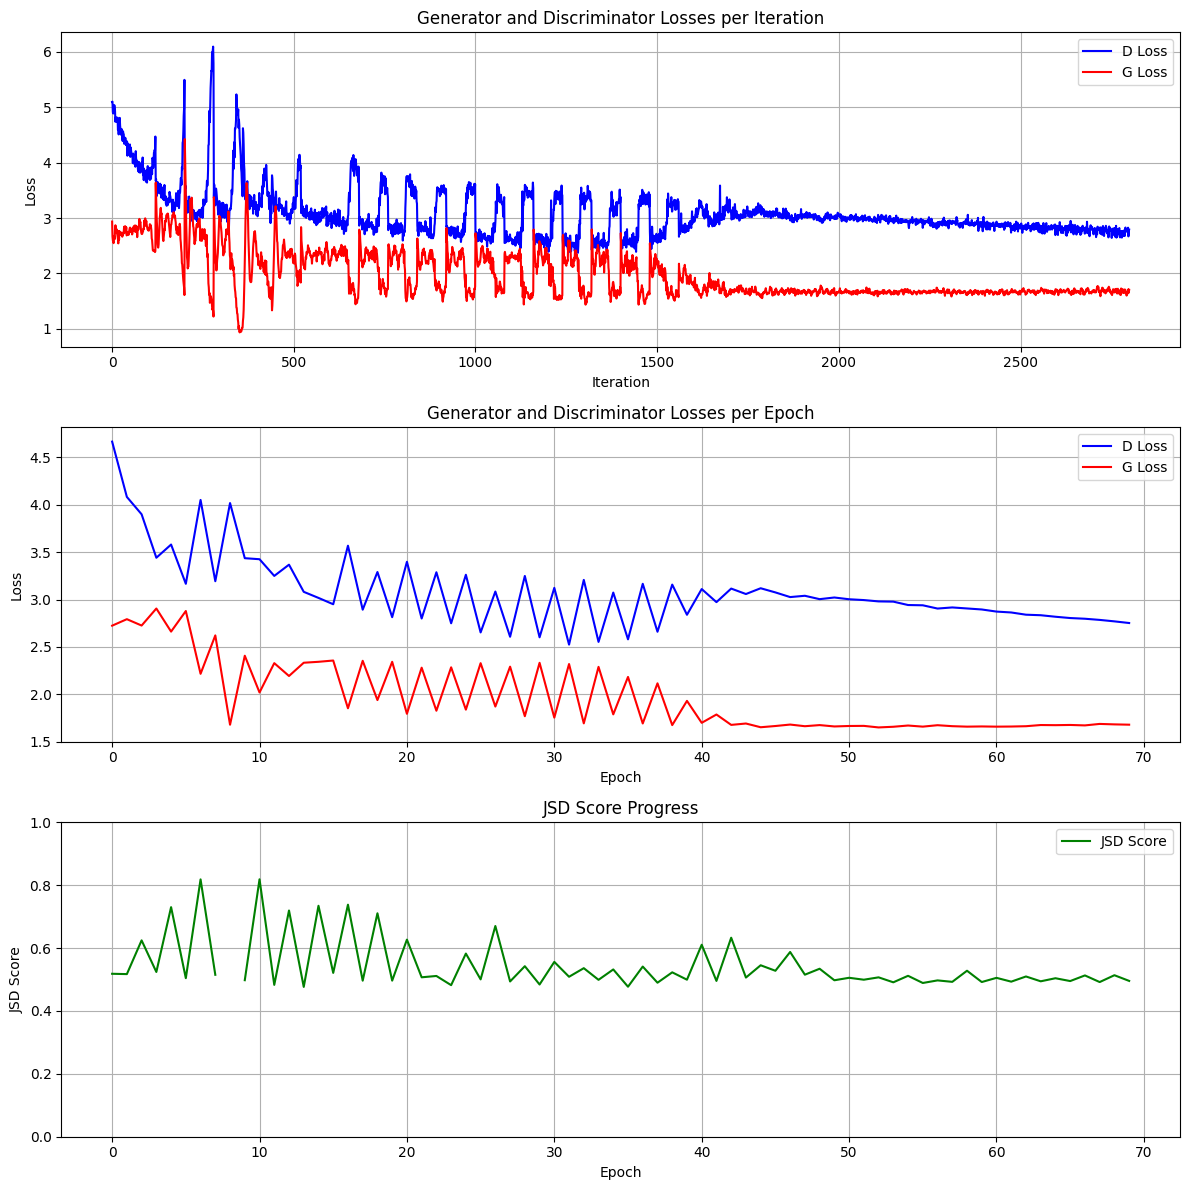

In [18]:
iteration_losses, total_iterations, jsd_history = train(generator, discriminator, dataloader,
                                                       num_epochs=70, d_step=1, g_step=1)

plot_metrics(
    iteration_losses=iteration_losses,
    jsd_history=jsd_history,
    total_iterations=total_iterations,
    num_epochs=150,
    dataloader_size=len(dataloader)
)